# Project

1. Central Idea
    - Idea: We analyze ~18,000 research papers related to Large Language Models and modern AI (LLMs, agentic AI, RAG, foundation models, transformers), downloaded from OpenAlex.
        Our goal is to reveal how ideas evolve in this field, and identify:
        - which topics dominate the field,
        - which papers are most influential,
        - which authors and institutions drive the research.
    - Why interesting? 
    LLMs are evolving extremely fast—every month there is a new architecture, agent framework, or RAG improvement. The public sees hype; we want to see the actual scientific movement.We want to know:
        - Are today's buzzwords (agents, reasoning, RAG) actually backed by science?
        - Who are the “idea hubs” (top-cited papers, institutions)?
        - Which topics are emerging vs. declining?
    - What datasets were explored? How did I download them? We are exploring a dataset of 20000 papers downloaded from OpenAlex. We used the query with parameters large language model|language model|pretrained language model|foundation model|transformer|LLM|agentic AI|AI agent|tool use|retrieval augmented generation|retrieval-augmented|model context protocol), later than 2000 and must have some references. 
2. Total Size of the Data. 17891 json files
    - Papers Citation Graph: 17891 nodes and 54295 edges
    - Co-autors graph: 65931 nodes, 285288 edges
    - Author Citation network: 55431 nodes, 2206140 edges
3. What is the network? - the oens rpesented above 
4. What is the text? The text is the actual text of the papers, and if that is absent we will use the abstract
5. How will text and networks be tied together? The text will be used to determine the most popular terms in the network, build communities and identify which authors defined popular technologies. 

## Papers Citation Graph

In [35]:
import os
import json
import networkx as nx

FOLDER = "papers_full"

G = nx.DiGraph()

def extract_id(url):
    if not url:
        return None
    return url.strip().split("/")[-1]

# Load all papers once into memory {paper_id: json_data}
paper_data = {}

print("Loading JSON files...")

for filename in os.listdir(FOLDER):
    if not filename.endswith(".json"):
        continue

    paper_id = filename.replace(".json", "")

    with open(os.path.join(FOLDER, filename), "r", encoding="utf-8") as f:
        data = json.load(f)

    paper_data[paper_id] = data

print(f"Loaded {len(paper_data)} papers")

print("Building graph...")

for paper_id, data in paper_data.items():

    # Convert authors from list -> single string
    authors = ", ".join([a.get("name") for a in data.get("authors", [])])
    concepts = ", ".join([c.get("name") for c in data.get("concepts", [])])
    institution_list = ", ".join(
    sorted({
        inst
        for author in data.get("authors", [])
        for inst in author.get("affiliations", [])
        if inst
    })
)


    G.add_node(
        paper_id,
        title=str(data.get("title") or ""),
        url = str(data.get("url") or ""),
        year=str(data.get("year") or ""),
        authors=authors,                      # <--- GEXF friendly
        abstract=str(data.get("abstract") or ""),  # keep abstract (short)
        topic=str(data.get("topic")),
        concepts = concepts,
        institutions_flat = institution_list
        # full_text removed (too big + not needed for graph format)
    )

    for ref_url in data.get("references", []):
        ref_id = extract_id(ref_url)
        if ref_id in paper_data:
            G.add_edge(paper_id, ref_id)


print("Graph completed.")
print(f"Nodes: {G.number_of_nodes()}")
print(f"Edges: {G.number_of_edges()}")


Loading JSON files...
Loaded 17891 papers
Building graph...
Graph completed.
Nodes: 17891
Edges: 54295


### Export the graph

In [ ]:
nx.write_gexf(G, "papers_citation_graph.gexf")


In [36]:
# Example centrality measures
pagerank = nx.pagerank(G)
degree = dict(G.out_degree())

# Sorted most cited (high indegree)
most_cited = sorted(G.in_degree(), key=lambda x: x[1], reverse=True)[:20]
print("Top 20 most cited papers (by indegree):")
for paper_id, indeg in most_cited:
    title = G.nodes[paper_id].get("title", "N/A")
    year = G.nodes[paper_id].get("year", "N/A")
    url = G.nodes[paper_id].get("url", "N/A")
    abstract_len = len(G.nodes[paper_id].get("abstract"))
    topic = G.nodes[paper_id].get("topic")
    concepts = G.nodes[paper_id].get("concepts")
    insitutions = G.nodes[paper_id].get("institutions_flat")
    print(f"{paper_id}, {url}\ntitle: {title}\nyear: {year}\nabstract length: {abstract_len}, topic: {topic},\nconcepts: {concepts}\ninstitutions: {insitutions}\n({indeg} citations)")
    print("____________________________________________________________________________________________________________________________________")

least_cited = sorted(G.in_degree(),key = lambda x: x[1], reverse=False)[:20]
print("Top 20 least cited papers (by ind-degree)")
for paper_id, indeg in least_cited:
    title = G.nodes[paper_id].get("title", "N/A")
    year = G.nodes[paper_id].get("year", "N/A")
    url = G.nodes[paper_id].get("url", "N/A")
    abstract_len = len(G.nodes[paper_id].get("abstract"))
    topic = G.nodes[paper_id].get("topic")
    concepts = G.nodes[paper_id].get("concepts")
    insitutions = G.nodes[paper_id].get("institutions_flat")

    print(f"{paper_id}, {url}\ntitle: {title}\nyear: {year}\nabstract length: {abstract_len}, topic: {topic},\nconcepts: {concepts}\ninstitutions: {insitutions}\n({indeg} citations)")
    print("____________________________________________________________________________________________________________________________________")



Top 20 most cited papers (by indegree):
W3094502228, https://openalex.org/W3094502228
title: An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale
year: 2022
abstract length: 854, topic: Image (mathematics),
concepts: Image (mathematics), Artificial intelligence, Transformer, Computer science, Computer vision, Scale (ratio), Engineering, Cartography, Electrical engineering, Geography, Voltage
institutions: 
(897 citations)
____________________________________________________________________________________________________________________________________
W4221143046, https://openalex.org/W4221143046
title: Chain-of-Thought Prompting Elicits Reasoning in Large Language Models
year: 2022
abstract length: 863, topic: Computer science,
concepts: Computer science, Language model, Benchmark (surveying), Chain (unit), Cognitive science, Artificial intelligence, Word (group theory), Natural language processing, Commonsense reasoning, Range (aeronautics), Simple (philosophy)

### Degree Distribution

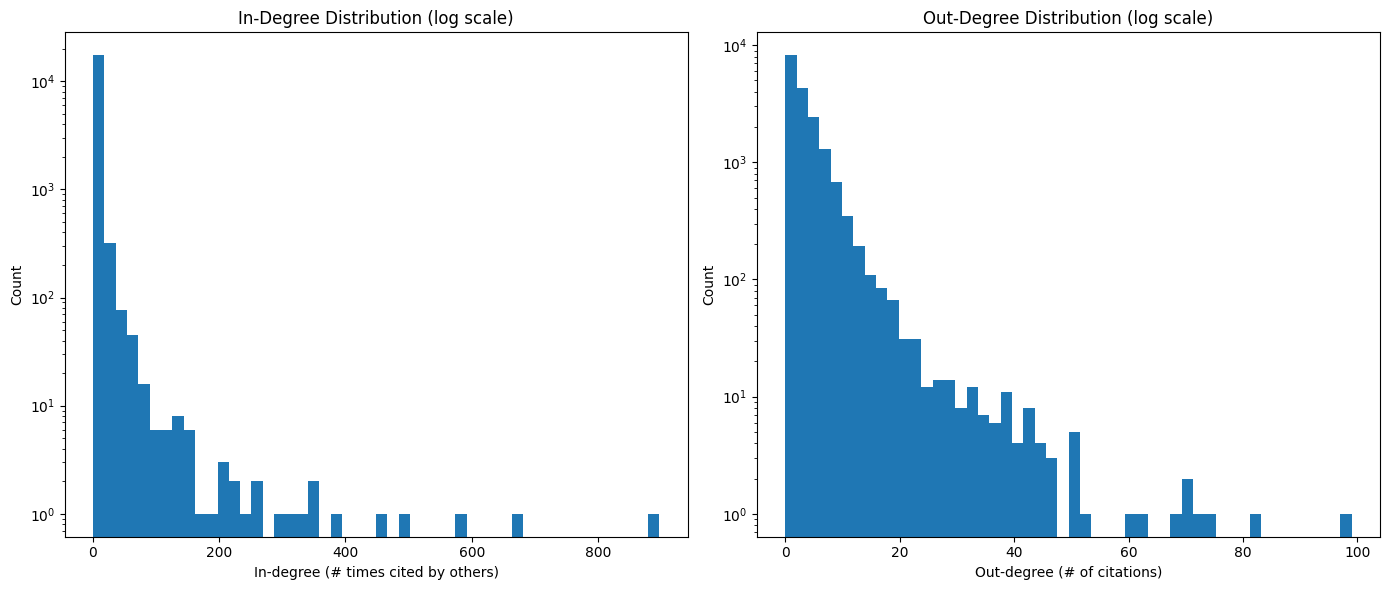

In [12]:
import matplotlib.pyplot as plt

in_degrees = [d for _, d in G.in_degree()]
out_degrees = [d for _, d in G.out_degree()]

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(in_degrees, bins=50, density=False)
plt.yscale("log")
plt.title("In-Degree Distribution (log scale)")
plt.xlabel("In-degree (# times cited by others)")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.hist(out_degrees, bins=50, density=False)
plt.yscale("log")
plt.title("Out-Degree Distribution (log scale)")
plt.xlabel("Out-degree (# of citations)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


### Co-authorship network

In [ ]:
# import networkx as nx
# import itertools
# import json
# import os

# G = nx.Graph()  # undirected co-authorship network

# for file in os.listdir("papers_full"):
#     if not file.endswith(".json"):
#         continue

#     with open(os.path.join("papers_full", file), encoding="utf-8") as f:
#         data = json.load(f)

#     # Extract only valid author IDs
#     authors = [a.get("id") for a in data.get("authors", []) if a.get("id")]

#     # Skip papers with fewer than 2 authors (no collaboration)
#     if len(authors) < 2:
#         continue

#     # Add authors as nodes
#     for author in authors:
#         G.add_node(author)

#     # Add undirected edges between co-authors
#     for a1, a2 in itertools.combinations(authors, 2):
#         G.add_edge(a1, a2)

# print("Nodes:", G.number_of_nodes())
# print("Edges:", G.number_of_edges())


In [ ]:
# ### Degree distribution of co-authors

# import matplotlib.pyplot as plt

# degrees = [d for _, d in G.degree()]

# plt.figure(figsize=(8, 6))
# plt.hist(degrees, bins=50, density=False)
# plt.yscale("log")
# plt.title("Co-authorship Network Degree Distribution (log scale)")
# plt.xlabel("Degree")
# plt.ylabel("Count")
# plt.show()


### Author Citation Network

In [ ]:
# import networkx as nx
# import os
# import json

# G = nx.DiGraph()

# # Preload all paper data
# papers = {
#     fname[:-5]: json.load(open("papers_full/" + fname, encoding="utf-8"))
#     for fname in os.listdir("papers_full")
#     if fname.endswith(".json")
# }

# for paper_id, data in papers.items():

#     # Extract only valid author IDs
#     authors = [a.get("id") for a in data.get("authors", []) if a.get("id")]

#     for ref_url in data.get("references", []):
#         ref_id = ref_url.split("/")[-1]
#         ref_paper = papers.get(ref_id)

#         if not ref_paper:
#             continue

#         # Extract referenced paper's author IDs (filter out None)
#         ref_authors = [a.get("id") for a in ref_paper.get("authors", []) if a.get("id")]

#         # Create directed edges author → referenced_author
#         for a in authors:
#             for b in ref_authors:
#                 if a and b:  # prevent invalid edges
#                     G.add_edge(a, b)

# print("✅ Author citation network built")
# print(f"Nodes: {G.number_of_nodes()}")
# print(f"Edges: {G.number_of_edges()}")


✅ Author citation network built
Nodes: 55431
Edges: 2206140


In [ ]:
# ### Degree distribution of authors citing each other
# import matplotlib.pyplot as plt

# in_degrees = [d for _, d in G.in_degree()]
# out_degrees = [d for _, d in G.out_degree()]
# plt.figure(figsize=(14, 6))
# plt.subplot(1, 2, 1)
# plt.hist(in_degrees, bins=50, density=False)
# plt.yscale("log")
# plt.title("Author Citation Network In-Degree Distribution (log scale)")
# plt.xlabel("In-degree (# times cited by other authors)")
# plt.ylabel("Count")
# plt.subplot(1, 2, 2)
# plt.hist(out_degrees, bins=50, density=False)
# plt.yscale("log")
# plt.title("Author Citation Network Out-Degree Distribution (log scale)")
# plt.xlabel("Out-degree (# times citing other authors)")
# plt.ylabel("Count")
# plt.tight_layout()
# plt.show()

# nx.write_gexf(G, "author_citation_network.gexf")